First, we import all the necessary libraries.

In [156]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import os
import pandas as pd

from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

from scipy.io import loadmat
from sklearn.utils import shuffle

# to keep track of how long it takes
from datetime import datetime

Our basic helper functions will give us the error rate, the rectifier linear unit function, and an indicator matrix for our predictions.

In [157]:
def error_rate(p, t):
    return np.mean(p != t)

def relu(a):
    return a * (a > 0)

def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

Our convpool function first performs the convolution on our input matrix given our filters. We downsample each feature map individually using maxpooling, and we set the poolsize to (2, 2). To add the bias term, we need to reshape our bias variable to a tensor of shape (1, n_filters, 1, 1), where each bias wil be broadcasted across mini-batches and feature map width and height. Our activation function will be the ReLu.

In [158]:
def convpool(X, W, b, poolsize=(2, 2)):
    conv_out = conv2d(input=X, filters=W)

    pooled_out = pool.pool_2d(
        input=conv_out,
        ds=poolsize,
        ignore_border=True
    )

    return relu(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))

The way we always initialize weights is random normal / sqrt(fan in + fan out). The key point is it's random with a variance restricted by the size.

In [159]:
# this is our weight initialization function, which takes in the dimensions
def init_filter(shape, poolsz):
    # this is the fan in plus fan out
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)

Next, we import our MNIST data, normalize it, and partition it into train and test samples. 

In [160]:
data = pd.read_csv(os.path.join('Data', 'train.csv'))

In [161]:
def get_normalized_data(data):
    data = data.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std
    Y = data[:, 0]
    return X, Y

In [162]:
X, Y = get_normalized_data(data)

In [163]:
X = X.reshape(len(X), 1, 28, 28)

In [164]:
X = X.astype(np.float32)

In [165]:
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

We set our hyperparameters, and we will add L2 regularization along with momentum.

In [166]:
max_iter = 30
print_period = 10

lr = np.float32(0.00004)
reg = np.float32(0.01)
mu = np.float32(0.9)

N = Xtrain.shape[0]
batch_sz = 500
n_batches = N / batch_sz

M = 500
K = 10
poolsz = (2, 2)

Our first convolution will have 20 feature maps, while our second convolution will have 50 feature maps. 

In [ ]:
# after conv will be of dimension 32 - 5 + 1 = 28
# after downsample 28 / 2 = 14
W1_shape = (20, 1, 5, 5) # (num_feature_maps, num_color_channels, filter_width, filter_height)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[0], dtype=np.float32) # one bias per output feature map

# after conv will be of dimension 14 - 5 + 1 = 10
# after downsample 10 / 2 = 5
W2_shape = (50, 20, 5, 5) # (num_feature_maps, old_num_feature_maps, filter_width, filter_height)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[0], dtype=np.float32)

# vanilla ANN weights
W3_init = np.random.randn(W2_shape[0]*4*4, M) / np.sqrt(W2_shape[0]*4*4 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

We define our shared variables, which include the weights and bias terms as well as the momentum changes for each one.

In [ ]:
# step 2: define theano variables and expressions
X = T.tensor4('X', dtype='float32')
Y = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')
W3 = theano.shared(W3_init.astype(np.float32), 'W3')
b3 = theano.shared(b3_init, 'b3')
W4 = theano.shared(W4_init.astype(np.float32), 'W4')
b4 = theano.shared(b4_init, 'b4')

# momentum changes
dW1 = theano.shared(np.zeros(W1_init.shape, dtype=np.float32), 'dW1')
db1 = theano.shared(np.zeros(b1_init.shape, dtype=np.float32), 'db1')
dW2 = theano.shared(np.zeros(W2_init.shape, dtype=np.float32), 'dW2')
db2 = theano.shared(np.zeros(b2_init.shape, dtype=np.float32), 'db2')
dW3 = theano.shared(np.zeros(W3_init.shape, dtype=np.float32), 'dW3')
db3 = theano.shared(np.zeros(b3_init.shape, dtype=np.float32), 'db3')
dW4 = theano.shared(np.zeros(W4_init.shape, dtype=np.float32), 'dW4')
db4 = theano.shared(np.zeros(b4_init.shape, dtype=np.float32), 'db4')

The forward pass will include our two convpool layer, followed by our fully connected neural network layer, and finishing with the softmax.

In [ ]:
# forward pass
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z3 = relu(Z2.flatten(ndim=2).dot(W3) + b3)
pY = T.nnet.softmax(Z3.dot(W4) + b4)

# define the cost function and prediction
params = (W1, b1, W2, b2, W3, b3, W4, b4)
reg_cost = reg*np.sum((param*param).sum() for param in params)
cost = -(Y * T.log(pY)).sum() + reg_cost
prediction = T.argmax(pY, axis=1)

Then, we define our update parameters, as well as the train and prediction functions.

In [167]:
# step 3: training expressions and functions
update_W1 = W1 + mu*dW1 - lr*T.grad(cost, W1)
update_b1 = b1 + mu*db1 - lr*T.grad(cost, b1)
update_W2 = W2 + mu*dW2 - lr*T.grad(cost, W2)
update_b2 = b2 + mu*db2 - lr*T.grad(cost, b2)
update_W3 = W3 + mu*dW3 - lr*T.grad(cost, W3)
update_b3 = b3 + mu*db3 - lr*T.grad(cost, b3)
update_W4 = W4 + mu*dW4 - lr*T.grad(cost, W4)
update_b4 = b4 + mu*db4 - lr*T.grad(cost, b4)

# update weight changes
update_dW1 = mu*dW1 - lr*T.grad(cost, W1)
update_db1 = mu*db1 - lr*T.grad(cost, b1)
update_dW2 = mu*dW2 - lr*T.grad(cost, W2)
update_db2 = mu*db2 - lr*T.grad(cost, b2)
update_dW3 = mu*dW3 - lr*T.grad(cost, W3)
update_db3 = mu*db3 - lr*T.grad(cost, b3)
update_dW4 = mu*dW4 - lr*T.grad(cost, W4)
update_db4 = mu*db4 - lr*T.grad(cost, b4)

train = theano.function(
    inputs=[X, Y],
    updates=
        [(W1, update_W1),
        (b1, update_b1),
        (W2, update_W2),
        (b2, update_b2),
        (W3, update_W3),
        (b3, update_b3),
        (W4, update_W4),
        (b4, update_b4)]+
        [(dW1, update_dW1),
        (db1, update_db1),
        (dW2, update_dW2),
        (db2, update_db2),
        (dW3, update_dW3),
        (db3, update_db3),
        (dW4, update_dW4),
        (db4, update_db4)]
    ,
)

# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[X, Y],
    outputs=[cost, prediction],
)

Lastly, we do our batch gradient decent and iterate through our dataset for the predetermined number of epochs. 

Cost / err at iteration i=0, j=0: 2353.433 / 0.883
Cost / err at iteration i=2, j=0: 69.560 / 0.028
Cost / err at iteration i=4, j=0: 56.687 / 0.017
Cost / err at iteration i=6, j=0: 43.612 / 0.011
Cost / err at iteration i=8, j=0: 39.772 / 0.013
Cost / err at iteration i=10, j=0: 37.467 / 0.011
Cost / err at iteration i=12, j=0: 42.521 / 0.014
Cost / err at iteration i=14, j=0: 36.269 / 0.011
Cost / err at iteration i=16, j=0: 41.879 / 0.012
Cost / err at iteration i=18, j=0: 45.308 / 0.018
Cost / err at iteration i=20, j=0: 38.035 / 0.012
Cost / err at iteration i=22, j=0: 39.195 / 0.013
Cost / err at iteration i=24, j=0: 40.340 / 0.011
Cost / err at iteration i=26, j=0: 40.878 / 0.011
Cost / err at iteration i=28, j=0: 42.515 / 0.013
Cost / err at iteration i=29, j=0: 40.796 / 0.011
Elapsed time: 0:17:31.629370


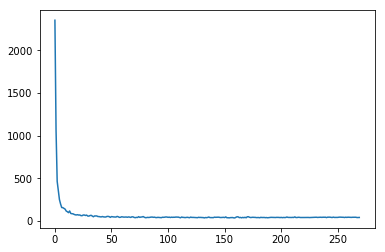

In [168]:
t0 = datetime.now()
LL = []
for i in range(max_iter):
    Xtrain, Ytrain_ind = shuffle(Xtrain, Ytrain_ind)
    for j in range(int(n_batches)):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            LL.append(cost_val)
            if (i % 2 == 0 or i % 29 == 0) and j % 100 == 0:
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
                
print("Elapsed time:", (datetime.now() - t0))
plt.plot(LL)
plt.show()